First : Mount the gdrive

Or run below command

from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

zip_ref = zipfile.ZipFile('/content/drive/MyDrive/Dataset/resized+grayscaled+noise_removal.zip', 'r') #Add path of the zip file
zip_ref.extractall('sample_data/dataset') #Extracts the files into the /tmp folder
zip_ref.close()


In [ ]:
directory_path = '/content/sample_data/dataset/resized+grayscaled+noise_removal'
len(os.listdir(directory_path))#16428

16428

In [ ]:
# for loading/processing the images
from tensorflow.keras.utils import load_img
from tensorflow.keras.utils import img_to_array
from keras.applications.vgg16 import preprocess_input

# models
from keras.applications.vgg16 import VGG16
from keras.models import Model

# clustering and dimension reduction
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# for everything else
import os
import numpy as np
import matplotlib.pyplot as plt
from random import randint
import pandas as pd
import pickle

In [ ]:
# change the working directory to the path where the images are located
os.chdir(directory_path)

# this list holds all the image filename
letters = []

# creates a ScandirIterator aliased as files
with os.scandir(directory_path) as files:
  # loops through each file in the directory
    for file in files:
        if file.name.endswith(('jpg', 'jpeg', 'png')):
          # adds only the image files to the flowers list
            letters.append(file.name)

In [ ]:
print(letters[:10])

['109a_1_103.jpg', '016a_1_114.jpg', '014a_1_15.jpg', '044a_1_119.jpg', '046a_1_17.jpg', '007a_1_46.jpg', '018a_1_78.jpg', '106a_1_68.jpg', '038a_1_16.jpg', '085a_1_41.jpg']


In [ ]:
print(len(letters))

16428


In [ ]:
# load model
model = VGG16()
# remove the output layer
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)

553467096/553467096 [==============================] - 3s 0us/step


In [ ]:
def extract_features(file, model):
    # load the image as a 224x224 array
    img = load_img(file, target_size=(224,224))
    img = np.array(img)
    # reshape the data for the model reshape(num_of_samples, dim 1, dim 2, channels)
    reshaped_img = img.reshape(1,224,224,3)
    # prepare image for model
    imgx = preprocess_input(reshaped_img)
    # get the feature vector
    features = model.predict(imgx, use_multiprocessing=True)
    return features

In [ ]:
data = {}
p = r"/content/drive/MyDrive/Documents/letters_features2_0.pkl"

In [ ]:
for letter in letters:
    # try to extract the features and update the dictionary
    try:
        feat = extract_features(letter,model)
        data[letter] = feat
    # if something fails, save the extracted features as a pickle file (optional)
    except:
        with open(p,'wb') as file:
            pickle.dump(data,file)

Streaming output truncated to the last 5000 lines.
1/1 [==============================] - 0s 57ms/step


In [ ]:
# get a list of the filenames
filenames = np.array(list(data.keys()))

In [ ]:
len(filenames)

16428

In [ ]:
# get a list of just the features
feat = np.array(list(data.values()))

In [ ]:
features = feat.reshape(feat.shape[0], -1)

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(features)

In [ ]:
pca = PCA()
pca.fit(scaled_features)
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

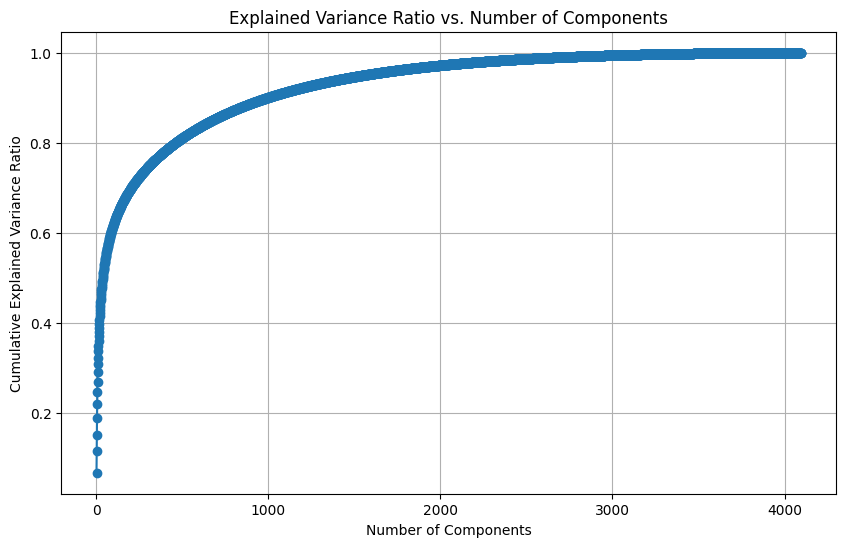

In [ ]:
plt.figure(figsize=(10, 6))
plt.plot(np.arange(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explained Variance Ratio')
plt.title('Explained Variance Ratio vs. Number of Components')
plt.grid(True)
plt.show()

In [ ]:
desired_variance = 0.95
n_components = np.argmax(cumulative_variance >= desired_variance) + 1

In [ ]:
print(f"Number of components to retain {desired_variance:.2%} variance: {n_components}")

Number of components to retain 95.00% variance: 1551


In [ ]:
pca = PCA(n_components=1551)
features_pca = pca.fit_transform(features)

In [ ]:
kmeans = KMeans(n_clusters=148, random_state=0)
cluster_labels = kmeans.fit_predict(features_pca)

/usr/local/lib/python3.10/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [ ]:
# holds the cluster id and the images { id: [images] }
groups = {}
for file, cluster in zip(filenames,kmeans.labels_):
    if cluster not in groups.keys():
        groups[cluster] = []
        groups[cluster].append(file)
    else:
        groups[cluster].append(file)

In [ ]:
def view_cluster(cluster):
    plt.figure(figsize = (25,25));
    # gets the list of filenames for a cluster
    files = groups[cluster]
    # only allow up to 30 images to be shown at a time
    if len(files) > 5:
        print(f"Clipping cluster size from {len(files)} to 30")
        files = files[:29]
    # plot each image in the cluster
    for index, file in enumerate(files):
        plt.subplot(10,10,index+1);
        img = load_img(file)
        img = np.array(img)
        plt.imshow(img)
        plt.axis('off')

In [ ]:
len(groups[0])

117

In [ ]:
len(groups)

148

In [ ]:
for i in range(len(groups)):
  print("Group: ",i,", number of images: ",len(groups[i]),", They are: ",groups[i])

Group:  0 , number of images:  89 , They are:  ['111a_1_51.jpg', '038a_1_51.jpg', '105a_1_51.jpg', '024a_1_51.jpg', '097a_1_51.jpg', '043a_1_51.jpg', '046a_1_51.jpg', '012a_1_51.jpg', '071a_1_51.jpg', '058a_1_51.jpg', '076a_1_51.jpg', '096a_1_51.jpg', '060a_1_51.jpg', '029a_1_51.jpg', '086a_1_51.jpg', '023a_1_47.jpg', '066a_1_51.jpg', '042a_1_51.jpg', '063a_1_51.jpg', '074a_1_51.jpg', '067a_1_51.jpg', '036a_1_51.jpg', '048a_1_51.jpg', '062a_1_51.jpg', '075a_1_51.jpg', '094a_1_51.jpg', '011a_1_47.jpg', '102a_1_51.jpg', '014a_1_51.jpg', '006a_1_51.jpg', '047a_1_51.jpg', '081a_1_51.jpg', '088a_1_51.jpg', '049a_1_51.jpg', '079a_1_51.jpg', '059a_1_51.jpg', '077a_1_51.jpg', '069a_1_51.jpg', '033a_1_51.jpg', '037a_1_51.jpg', '056a_1_51.jpg', '016a_1_51.jpg', '073a_1_51.jpg', '110a_1_51.jpg', '070a_1_51.jpg', '004a_1_47.jpg', '013a_1_51.jpg', '020a_1_51.jpg', '072a_1_51.jpg', '104a_1_51.jpg', '057a_1_51.jpg', '068a_1_51.jpg', '053a_1_51.jpg', '027a_1_51.jpg', '083a_1_51.jpg', '015a_1_51.jpg', 

In [ ]:
for i in range(len(groups)):
  print(i,groups[i])

0 ['111a_1_51.jpg', '038a_1_51.jpg', '105a_1_51.jpg', '024a_1_51.jpg', '097a_1_51.jpg', '043a_1_51.jpg', '046a_1_51.jpg', '012a_1_51.jpg', '071a_1_51.jpg', '058a_1_51.jpg', '076a_1_51.jpg', '096a_1_51.jpg', '060a_1_51.jpg', '029a_1_51.jpg', '086a_1_51.jpg', '023a_1_47.jpg', '066a_1_51.jpg', '042a_1_51.jpg', '063a_1_51.jpg', '074a_1_51.jpg', '067a_1_51.jpg', '036a_1_51.jpg', '048a_1_51.jpg', '062a_1_51.jpg', '075a_1_51.jpg', '094a_1_51.jpg', '011a_1_47.jpg', '102a_1_51.jpg', '014a_1_51.jpg', '006a_1_51.jpg', '047a_1_51.jpg', '081a_1_51.jpg', '088a_1_51.jpg', '049a_1_51.jpg', '079a_1_51.jpg', '059a_1_51.jpg', '077a_1_51.jpg', '069a_1_51.jpg', '033a_1_51.jpg', '037a_1_51.jpg', '056a_1_51.jpg', '016a_1_51.jpg', '073a_1_51.jpg', '110a_1_51.jpg', '070a_1_51.jpg', '004a_1_47.jpg', '013a_1_51.jpg', '020a_1_51.jpg', '072a_1_51.jpg', '104a_1_51.jpg', '057a_1_51.jpg', '068a_1_51.jpg', '053a_1_51.jpg', '027a_1_51.jpg', '083a_1_51.jpg', '015a_1_51.jpg', '091a_1_51.jpg', '007a_1_47.jpg', '064a_1_51.

above output format: group_id [elements of that group]

In [ ]:
for i in range(len(groups)):
  print(groups[i])

['111a_1_51.jpg', '038a_1_51.jpg', '105a_1_51.jpg', '024a_1_51.jpg', '097a_1_51.jpg', '043a_1_51.jpg', '046a_1_51.jpg', '012a_1_51.jpg', '071a_1_51.jpg', '058a_1_51.jpg', '076a_1_51.jpg', '096a_1_51.jpg', '060a_1_51.jpg', '029a_1_51.jpg', '086a_1_51.jpg', '023a_1_47.jpg', '066a_1_51.jpg', '042a_1_51.jpg', '063a_1_51.jpg', '074a_1_51.jpg', '067a_1_51.jpg', '036a_1_51.jpg', '048a_1_51.jpg', '062a_1_51.jpg', '075a_1_51.jpg', '094a_1_51.jpg', '011a_1_47.jpg', '102a_1_51.jpg', '014a_1_51.jpg', '006a_1_51.jpg', '047a_1_51.jpg', '081a_1_51.jpg', '088a_1_51.jpg', '049a_1_51.jpg', '079a_1_51.jpg', '059a_1_51.jpg', '077a_1_51.jpg', '069a_1_51.jpg', '033a_1_51.jpg', '037a_1_51.jpg', '056a_1_51.jpg', '016a_1_51.jpg', '073a_1_51.jpg', '110a_1_51.jpg', '070a_1_51.jpg', '004a_1_47.jpg', '013a_1_51.jpg', '020a_1_51.jpg', '072a_1_51.jpg', '104a_1_51.jpg', '057a_1_51.jpg', '068a_1_51.jpg', '053a_1_51.jpg', '027a_1_51.jpg', '083a_1_51.jpg', '015a_1_51.jpg', '091a_1_51.jpg', '007a_1_47.jpg', '064a_1_51.jp

In [ ]:
group=[]
for i in range(148):
  group.append(i)
len(group)

148

In [ ]:
val=[89,134,113,74,112,125,108,149,86,134,162,91,101,176,164,104,88,124,161,105,94,78,125,102,64,113,92,128,154,142,118,69,99,205,121,126,104,163,59,118,58,149,125,118,74,80,80,123,147,84,84,46,88,155,66,116,138,103,138,134,209,141,139,77,99,84,167,156,94,90,83,70,92,110,135,115,132,78,77,175,184,124,152,85,65,90,96,46,155,122,93,125,74,90,138,117,128,132,38,146,124,139,84,96,102,75,93,144,49,129,114,96,58,102,113,170,129,150,143,70,117,49,120,98,85,109,91,97,66,145,112,88,145,127,65,161,82,81,148,63,108,94,140,121,79,140,190,24]
len(val)

148

In [ ]:
type(val[1])

int

In [ ]:
import matplotlib.pyplot as plt

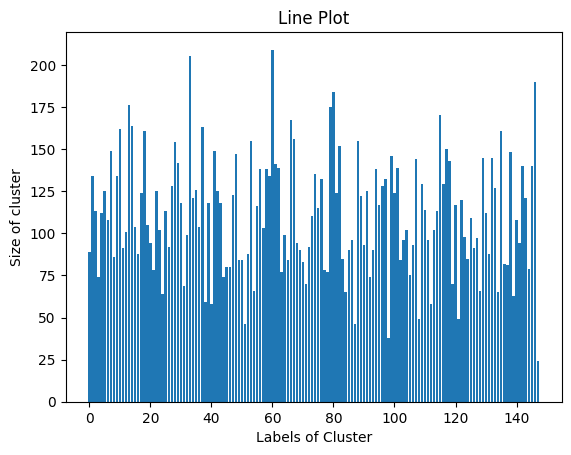

In [ ]:
plt.bar(group, val)
plt.xlabel('Labels of Cluster')
plt.ylabel('Size of cluster')
plt.title('Line Plot')
plt.show()

In [ ]:
print(min(val))
print(max(val))
print(max(val)-min(val))

24
209
185
